# Stock Price Prediction

Here we have a basic script for stock price prediction based on a $\textit{Long Short-Term Memory}$ (LSTM), which is a particular type of $\textit{Recurrent Neural Networks}$. 

RNNs are a particular type of NN designed to handle sequential data. Each layer repeatedly applies the same weights over a sequence, updating hidden states step-by-step, capturing temporal dependencies.

LSTM it’s a special kind of RNN designed to better handle long-term dependencies in sequences. They use memory cells and gates (forget, input, and output gates) that control how information flows in and out. In this way, they are able to retain important information for long periods and forget irrelevant details, allowing them to capture both short-term fluctuations and long-term dependencies better than vanilla RNNs.

In [1]:
import numpy as np 
import pandas as pd 
import yfinance as yf
import matplotlib.pyplot as plt 

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
ticker = 'NIO'
df = yf.download(ticker,'2015-01-01')

C:\Users\nino\AppData\Local\Temp\ipykernel_15964\1796756145.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker,'2015-01-01')
[*********************100%***********************]  1 of 1 completed


In [4]:
df

Price,Close,High,Low,Open,Volume
Ticker,NIO,NIO,NIO,NIO,NIO
Date,,,,,
2018-09-12,6.60,6.93,5.35,6.00,66849000
2018-09-13,11.60,12.69,6.52,6.62,158346500
2018-09-14,9.90,13.80,9.22,12.66,172473600
2018-09-17,8.50,9.75,8.50,9.61,56323900
2018-09-18,7.68,9.10,7.67,8.73,41827600
...,...,...,...,...,...
2025-10-14,6.80,7.00,6.77,6.90,56830400
2025-10-15,6.82,7.04,6.74,6.99,40112300


<Axes: xlabel='Date'>

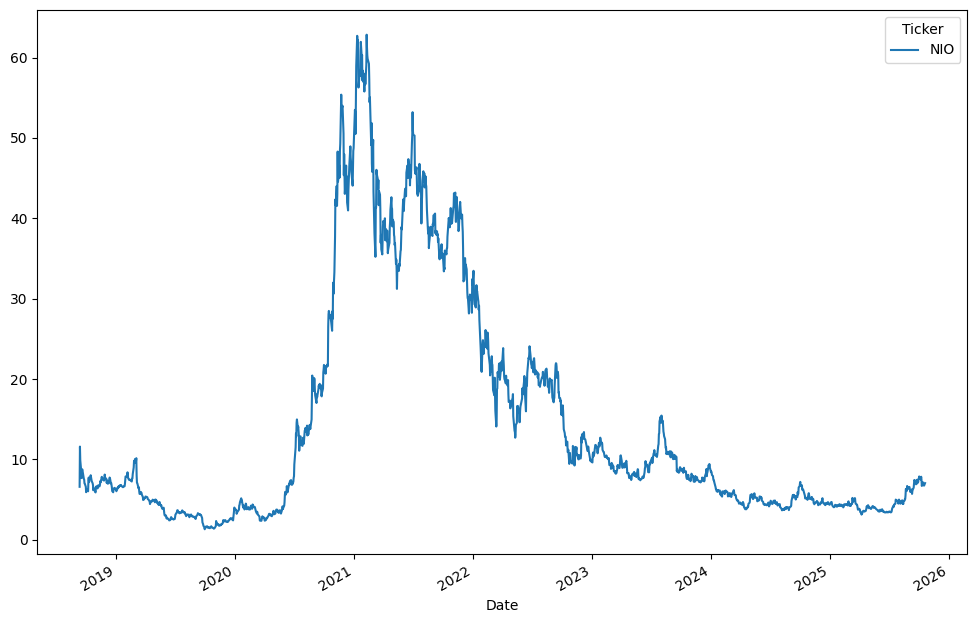

In [5]:
df.Close.plot(figsize = (12,8))

In [6]:
scaler = StandardScaler()

df['Close'] = scaler.fit_transform(df['Close'])

`StandardScaler()` is a normalization tool from `sklearn.preprocessing` used to standardize your data so that its mean becomes $0$ and the standard deviation $1$. This is known as $\textit{Z-score}$ normalization, and it’s done using the formula: $$z = \frac{x-\mu}{\sigma}$$

We do this because the model learns better if the stock prices are centered around zero and scaled, rather than having large raw numbers. This helps it capture patterns and relationships in the data effectively.

<Axes: xlabel='Date'>

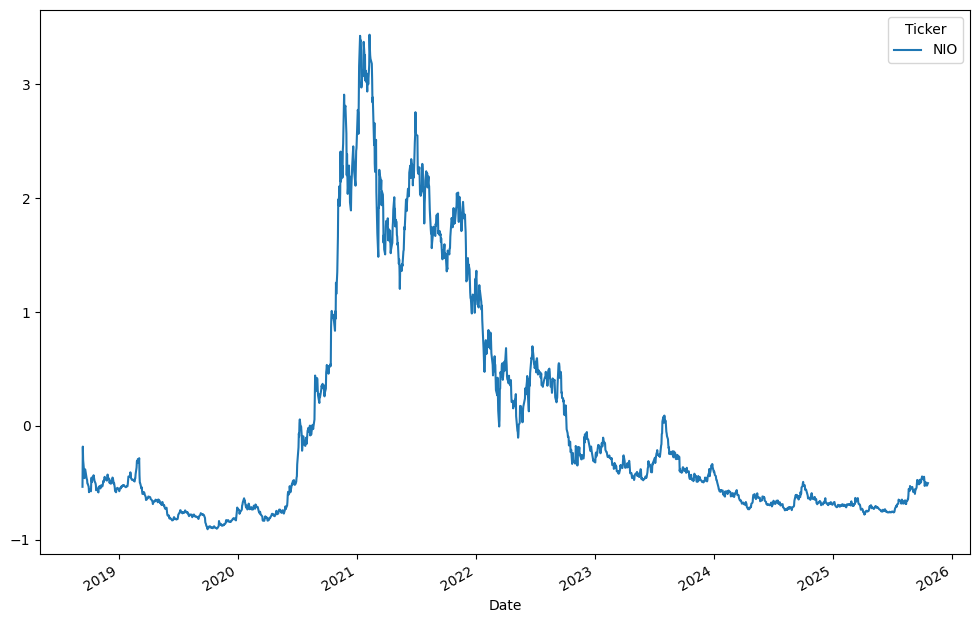

In [7]:
df['Close'].plot(figsize=(12,8))

In [8]:
seq_length = 101
data = []

for i in range(len(df) - seq_length):
    data.append(df.Close[i:i+seq_length])

data = np.array(data)

In [9]:
train_size = int(0.8 * len(data)) # Define which fraction of the dataset will be used for the training and for the 
                                  # test, respectively.

x_train = torch.from_numpy(data[:train_size, :-1, :]).type(torch.Tensor).to(device)
y_train = torch.from_numpy(data[:train_size, -1, :]).type(torch.Tensor).to(device)
x_test= torch.from_numpy(data[train_size:, :-1, :]).type(torch.Tensor).to(device)
y_test = torch.from_numpy(data[train_size:, -1, :]).type(torch.Tensor).to(device)

In [10]:
class PredictionModel(nn.Module):
    def __init__(self,input_dim, hidden_dim, num_layers, output_dim):
        super(PredictionModel, self).__init__()
        
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first = True,)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device = device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device = device)

        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:,-1,:])  

        return out

- `hidden_dim` is the size of the hidden state vector in an LSTM (or any RNN). It represents how many features or “memory slots” the network uses at each time step to store information about the sequence. A larger `hidden_dim` means the model can capture more complex patterns but requires more computation. This parameter is the same for all the LSTM layers. They also define the dimension of the $\textit{Cell State}$ and the $\textit{Hidden State}$.
  - $\textit{Cell State}$: Long-term memory, carries info over time with minor changes
  - $\textit{Hidden State}$: Short-term memory, current output of the LSTM layer at each time step
  They hold “memory” or the internal state of the LSTM at that particular time, and are initialized to zero.

- `.detach()` ensures that these initial states are treated as constants, not variables to track gradients for. This is important because the initial states are reset at each forward pass and aren’t parameters to learn.

In [11]:
model = PredictionModel(input_dim = 1, hidden_dim = 64, num_layers = 2, output_dim = 1).to(device)

In [12]:
criterion = nn.MSELoss() # Loss function used to calculate how far off predictions are from true values.

optimizer = optim.Adam(model.parameters(), lr = 0.01)

In [13]:
num_epochs = 200

for i in range(num_epochs):
    y_train_pred = model(x_train)

    loss = criterion(y_train_pred, y_train)

    if i % 25 == 0:
        print(i, loss.item())

    optimizer.zero_grad() # Reset gradients before backpropagation
    loss.backward()       # Compute gradients
    optimizer.step()      # Update model parameters  

0 1.2211569547653198
25 0.016254855319857597
50 0.008169331587851048
75 0.006999715697020292
100 0.006487912032753229
125 0.00623955437913537
150 0.006113248411566019
175 0.006026648450642824


In [14]:
model.eval() # Switch model to evaluation mode 

y_test_pred = model(x_test) # Predict on the test set (no gradient tracking here)

# Inverse transform: convert predictions and targets back to original scale (e.g., real stock prices)
y_train_pred = scaler.inverse_transform(y_train_pred.detach().cpu().numpy())
y_train = scaler.inverse_transform(y_train.detach().cpu().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().cpu().numpy())
y_test = scaler.inverse_transform(y_test.detach().cpu().numpy())

In [15]:
# RMSE evaluation: quantify how far off, on average, the model’s predictions are from the real prices
train_rmse = root_mean_squared_error(y_train[:, 0], y_train_pred[:, 0])
test_rmse = root_mean_squared_error(y_test[:, 0], y_test_pred[:, 0])

In [16]:
print('Train RMSE: ',np.round(train_rmse,2),'$')

Train RMSE:  1.09 $


In [17]:
print('Test RMSE: ',np.round(test_rmse,2),'$')

Test RMSE:  0.26 $


### Useful Definition:
In modern machine learning and statistics, a $\textit{Regression Task}$ is defined as a task where the model learns a function to predict a continuous (real-valued) output from input data.

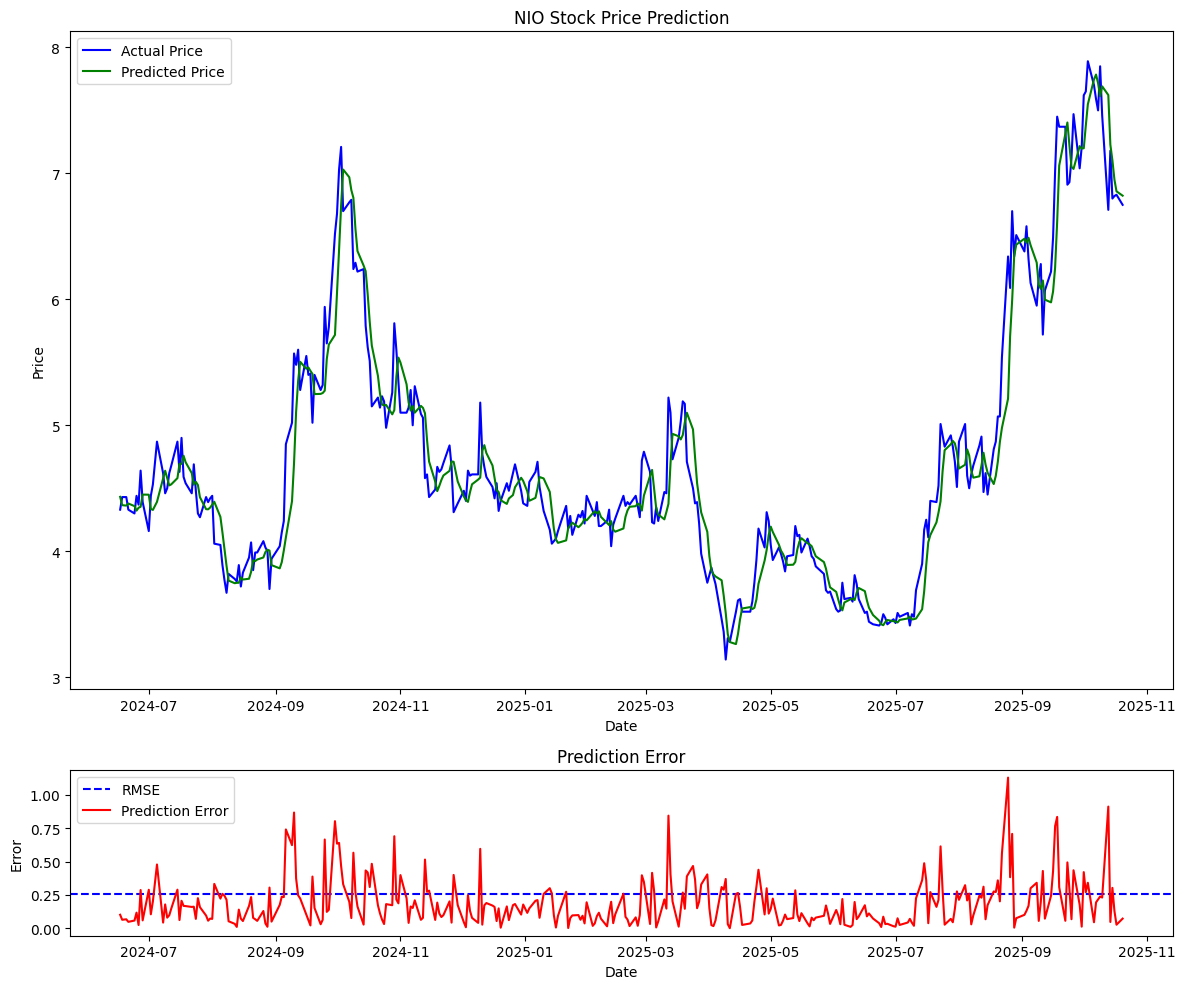

In [18]:
fig = plt.figure(figsize = (12,10))

gs = fig.add_gridspec(4,1)

ax1 = fig.add_subplot(gs[:3, 0])
ax1.plot(df.iloc[-len(y_test):].index, y_test, color = 'blue', label = 'Actual Price')
ax1.plot(df.iloc[-len(y_test):].index, y_test_pred, color = 'green', label = 'Predicted Price')
ax1.legend()
plt.title(f"{ticker} Stock Price Prediction")
plt.xlabel('Date')
plt.ylabel('Price')

ax2 = fig.add_subplot(gs[3,0])
ax2.axhline(test_rmse, color = 'blue', linestyle = '--', label = 'RMSE')
ax2.plot(df[-len(y_test):].index, abs(y_test - y_test_pred), 'r', label = 'Prediction Error')
ax2.legend()
plt.title('Prediction Error')
plt.xlabel('Date') 
plt.ylabel('Error')
plt.tight_layout()
plt.show()

### !!! Note the presence of a delay between the predicted data and the real ones.

# Is this model useful? 
Obviously (and unfortnately), this model is cannot be used to become rich, and it is just a funny model which is usefull to understand LSTM. 

To show this we will consider a very simple example:
- One dollar of initial investment
- Sell if the prediction of the next day is Red
- Buy (or maintain) if it is Green

Initial Value:  1 $
Final Value:  1.29 $
Relative Variation: 29.26 %


C:\Users\nino\AppData\Local\Temp\ipykernel_15964\3071897234.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  variation_over_time[i] = value
C:\Users\nino\AppData\Local\Temp\ipykernel_15964\3071897234.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  variation_over_time[i] = value


Text(0, 0.5, 'Capital ($)')

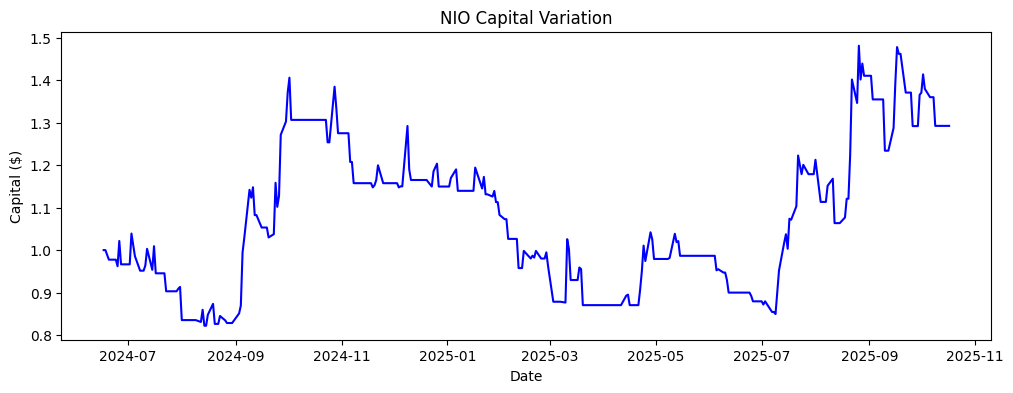

In [19]:
start_value = 1 #$
value = start_value
variation_over_time = np.zeros(len(y_test_pred)-1)

for i in range(len(y_test_pred)-1):
    predicted_relative_increment =  (y_test_pred[i+1] - y_test_pred[i])/y_test_pred[i]
    if predicted_relative_increment>0:
        real_relative_increment =  (y_test[i+1] - y_test[i])/y_test[i]
        value*= 1+real_relative_increment
        variation_over_time[i] = value
    else:   
        variation_over_time[i] = value
final_value = value[0]
relative_increment = final_value/start_value 
print('Initial Value: ',np.round(start_value,2),'$')
print('Final Value: ',np.round(final_value,2),'$')
print('Relative Variation:', np.round(relative_increment*100 - 100,2),'%')

fig = plt.figure(figsize = (12,4))

gs = fig.add_gridspec(4,1)


plt.plot(df.iloc[-len(y_test):-1].index, variation_over_time, color = 'blue')
plt.title(f"{ticker} Capital Variation")
plt.xlabel('Date')
plt.ylabel('Capital ($)')


### Conclusion
The trend of the Capital Variation follows the trend of the stock. A good prediction model should have an increasing Capital Variation trend. 

In conclusion, this model is not useful for making stock price predictions!!! 